# Letters

## Description

Generate an image with the edges of the letters present in this noisy image

## Group 5
- Francisco Macedo Ferreira PG55942
- Júlio José Medeiros Pereira Pinto PG57883
- Ivan Sérgio Rocha Ribeiro PG55950



In [260]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

fname = 'Letters-noisy.png'
operations = {}
pipeline_order = []
masks = []

# Operations

### IDFT


In [261]:
def compute_idft(dft):
    dft = np.fft.ifftshift(dft)
    img_back = cv2.idft(dft)
    return cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

operations['idft'] = compute_idft
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>}


### DTF

In [262]:
def compute_dft(img):
    # Convert image to float32 if needed
    if img.dtype != np.float32:
        img = np.float32(img)
    
    dft = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft)

operations['dft'] = compute_dft
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>}


### Inpaint (Black and White)

To remove the black and white pixels we decided to use the function inpaint from OpenCV. It allows us to use different interpolation methods. We decided to use Telea’s Fast Marching Method (`cv2.INPAINT_TELEA`).

In [263]:
# Inpainting
def inpaint_image(img):
    mask = (img == 0) | (img == 255)
    mask = mask.astype(np.uint8) * 255
    
    return cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

operations['inpaint'] = inpaint_image
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>}


### Threshold Filter

In [264]:
def apply_thresholding(img, plots=True):
    
    if img.dtype != np.uint8:
       img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Normaliza para [0, 255]
       img = img.astype(np.uint8)  # Converte para uint8
        
    # Calcular histograma
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    
    # Global Thresholding
    _, Gthres = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    
    # Otsu Thresholding
    _, Othres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Adaptive Thresholding
    Athres = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 1)
    
    masks.append(Gthres)
    masks.append(Othres)
    masks.append(Athres)
    
    if not(plots):
        fig, axs = plt.subplots(3, 2, figsize=(12, 24))
        axs[0, 0].imshow(img, cmap='gray')
        axs[0, 0].set_title('Original')
        axs[0, 0].axis('off')
        
        axs[0, 1].plot(hist)
        axs[0, 1].set_xlim([0, 256])
        axs[0, 1].set_title('Histogram')
        axs[0, 1].axis('off')
        
        axs[1, 0].imshow(Gthres, cmap='gray')
        axs[1, 0].set_title('Global Thresholding')
        axs[1, 0].axis('off')
        
        axs[1, 1].imshow(Othres, cmap='gray')
        axs[1, 1].set_title('Otsu Thresholding')
        axs[1, 1].axis('off')
        
        axs[2, 0].imshow(Athres, cmap='gray')
        axs[2, 0].set_title('Adaptive Thresholding')
        axs[2, 0].axis('off')
        
        plt.show()
    
    return apply_mask(img, masks[1], True)

# Adiciona ao dicionário de operações
operations['thresholding'] = apply_thresholding

### Gaussian Blurs


In [265]:

def apply_gaussian_blur(img):
        
    # Apply Gaussian blur to the entire image
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Create a copy of the original image
    result_img = img.copy()
    
    # Apply the blurred image only where masks[1] is
    if(masks is not None):
        result_img[masks[1] == 0] = blurred_img[masks[1] == 0]

    return result_img

# Example usage
operations['gaussian'] = apply_gaussian_blur
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>}


### Sobel Magnitude

In [266]:
def sobel_mag(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    return np.sqrt(np.power(sobelx,2)+np.power(sobely,2))

operations['sobel'] = sobel_mag
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>}


### Contrast

In [267]:
def apply_contrast(img):
    # Convert to uint8 for histogram equalization
    img_uint8 = img.astype(np.uint8)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(img_uint8)
    return equalized

operations['contrast'] = apply_contrast
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>}


### Bilateral Filter

In [268]:
def apply_bilateral_filter(image):
    # guarantee is the correct image type
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.bilateralFilter(image, d=15, sigmaColor=90, sigmaSpace=90)

operations['bilateral'] = apply_bilateral_filter
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>}


### CLAHE

In [269]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    if image.dtype != np.uint8:  # Ensure correct data type for CLAHE
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    processed_image = clahe.apply(image)
    
    return processed_image.astype(np.float32) / 255.0  # Normalize back to float32 range [0, 1]



operations['clahe'] = apply_clahe
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>}


## Frequency Filters

### Low-Pass Frequency Filter

We tested with both a circular center as well as rectangular, it didn´t impact the image as much as we would like

In [270]:
# Apply Low-pass Frequency Filter
def apply_low_pass_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    mask = np.zeros((rows, cols, 2), np.uint8)
    r = 35
    # cv2.circle(mask, (ccol, crow), 30, (1, 1), -1)
    cv2.rectangle(mask, (ccol - r, crow - r + 10), (ccol + r, crow + r - 10), (1, 1), -1)
    return dft * mask

operations['low_pass'] = apply_low_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>}


### High-Pass Frequency Filter

It was rather useless but we though we might as well try.

In [271]:
# Apply High-pass Frequency Filter
def apply_high_pass_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    mask = np.ones((rows, cols, 2), np.uint8)
    cv2.circle(mask, (ccol, crow), 30, (0, 0), -1)
    return dft * mask

operations['high_pass'] = apply_high_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>}


### Unsharp Mask


In [272]:
def apply_unsharp_mask(dft, sigma=1.0, strength=1.5):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols, 2), np.float32) 
    
    cv2.circle(mask, (ccol, crow), int(sigma * min(rows, cols)), (1 + strength, 1 + strength), -1)

    sharpened_dft = dft * mask

    return sharpened_dft

operations['unsharp'] = apply_unsharp_mask
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>}


## Notch Filters

### Regular Notch Filter

In terms of removing the "checkboard" like effect this was one of the most useful approaches

In [273]:
# Apply Notch Filter
def apply_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol - 30, crow - 20, 10), (ccol + 30, crow + 20, 10), (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10),
                     (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                     ]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (0, 0), -1)
    return dft * mask

operations['notch'] = apply_notch_filter
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>, 'notch': <function apply_notch_filter at 0x7bc9de7ca0c0>}


### Donut Notch Filter

Just something different we decided to try.


In [274]:
# Apply Donut Notch Filter
def apply_donut_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol - 30, crow - 20, 10, 30), (ccol + 30, crow + 20, 10, 30)]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    
    for x, y, r_inner, r_outer in notch_centers:
        cv2.circle(mask, (x, y), r_outer, (0, 0), -1)
        cv2.circle(mask, (x, y), r_inner, (1, 1), -1)
    return dft * mask

operations['donut'] = apply_donut_notch_filter
print(operations)


{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>, 'notch': <function apply_notch_filter at 0x7bc9de7ca0c0>, 'donut': <function apply_donut_notch_filter at 0x7bc9e430cc20>}


### Inverted Notch Filter

Very much like the Low-Pass filter, but this implementations give us a bit more of a way to test it. We tested it with the regular notch_centers array from the Notch Center Function but it looked awful.

In [275]:

# Apply Inversed Notch Filter
def apply_inversed_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol, crow, 30)]

    mask = np.zeros((rows, cols, 2), np.uint8)
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (1, 1), -1)
    return dft * mask

operations['inversed_notch'] = apply_inversed_notch_filter
print(operations)

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>, 'notch': <function apply_notch_filter at 0x7bc9de7ca0c0>, 'donut': <function apply_donut_notch_filter at 0x7bc9e430cc20>, 'inversed_notch': <function apply_inversed_notch_filter at 0x7bc9de7cbe20>}


# Helper Functions


### Load Image & Analyzing


{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>, 'notch': <function apply_notch_filter at 0x7bc9de7ca0c0>, 'donut': <function apply_donut_notch_filter at 0x7bc9e430cc20>, 'inversed_notch': <function apply_inversed_notch_filter at 0x7bc9de7cbe20>, 'analyze': <function apply_analyze_image at 0x7bc9e44e3ce0>}


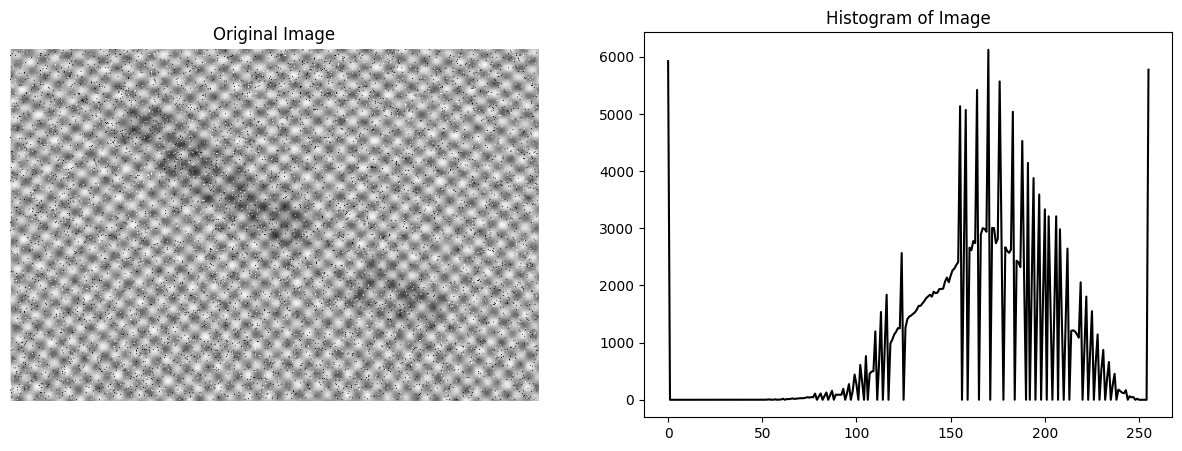

In [276]:

def analyze_image(img):
    hist = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
    return hist

def apply_analyze_image(img):
    hist = analyze_image(img)
    # Just the histogram
    plt.plot(hist, color='black')
    plt.title('Histogram of Image')
    plt.show()

    return img

operations['analyze'] = apply_analyze_image
print(operations)


def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    hist = analyze_image(img)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].plot(hist, color='black')
    axes[1].set_title('Histogram of Image')
    plt.show()

    return np.float32(img)

data = load_image(fname)

### Plots


In [277]:
def plot_result(data, title):
    if data.ndim == 2:  # Spatial domain
        plt.figure()
        plt.title(title)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        plt.show()
    elif data.ndim == 3 and data.shape[-1] == 2:  # Frequency domain
        magnitude_spectrum = 20 * np.log(cv2.magnitude(data[:, :, 0], data[:, :, 1]) + 1)
        img = compute_idft(data)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Reconstructed Image')
        axes[0].axis('off')
        
        axes[1].imshow(magnitude_spectrum, cmap='gray')
        axes[1].set_title('Magnitude Spectrum')
        axes[1].axis('off')
        plt.show()

### Masks Function

In [278]:
def apply_mask(img, mask, inverted=False):
    """
    Aplica uma máscara binária a uma imagem.

    Parâmetros:
    - img: numpy array, imagem de entrada (grayscale ou colorida).
    - mask: numpy array, máscara binária (0 e 255).
    - inverted: bool, se True, aplica a máscara invertida (mantém áreas pretas).

    Retorna:
    - Imagem mascarada com fundo preto.
    """
    # Garantir que a máscara seja binária (0 e 255)
    mask = (mask > 0).astype(np.uint8) * 255  

    # Inverter a máscara se necessário
    if inverted:
        mask = cv2.bitwise_not(mask)

    # Se a imagem for colorida, converter a máscara para 3 canais
    if len(img.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Aplicar a máscara à imagem
    result = cv2.bitwise_and(img, mask)
    
    result = inpaint_image(result)
    
    return result

# Main Function

In [281]:
print(operations)
print(masks)

def run_pipeline(data, pipe, debug=True):
    for step in pipe:
        data = operations[step](data)
        if debug:
            print(f"Step: {step}")
            plot_result(data, step)

    plot_result(data, "Final Result")

{'idft': <function compute_idft at 0x7bc9ef2a6c00>, 'dft': <function compute_dft at 0x7bc9e4591bc0>, 'inpaint': <function inpaint_image at 0x7bc9e4591da0>, 'thresholding': <function apply_thresholding at 0x7bc9e45936a0>, 'gaussian': <function apply_gaussian_blur at 0x7bc9e45a6480>, 'sobel': <function sobel_mag at 0x7bc9e4590e00>, 'contrast': <function apply_contrast at 0x7bc9e430d800>, 'bilateral': <function apply_bilateral_filter at 0x7bc9e4593ec0>, 'clahe': <function apply_clahe at 0x7bc9e45a72e0>, 'low_pass': <function apply_low_pass_filter at 0x7bc9dedc7240>, 'high_pass': <function apply_high_pass_filter at 0x7bc9e4593600>, 'unsharp': <function apply_unsharp_mask at 0x7bc9e4590720>, 'notch': <function apply_notch_filter at 0x7bc9de7ca0c0>, 'donut': <function apply_donut_notch_filter at 0x7bc9e430cc20>, 'inversed_notch': <function apply_inversed_notch_filter at 0x7bc9de7cbe20>, 'analyze': <function apply_analyze_image at 0x7bc9e44e3ce0>}
[]


### Multilpe Pipeline Tests

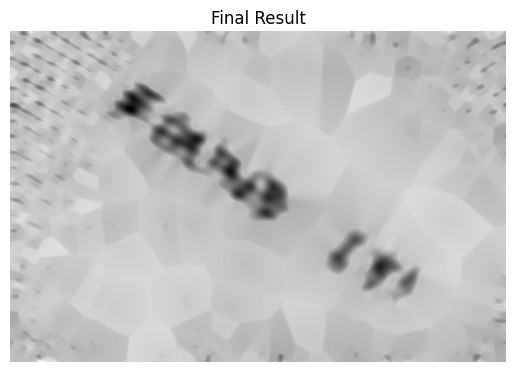

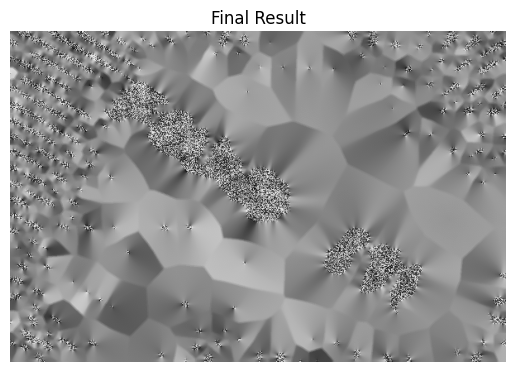

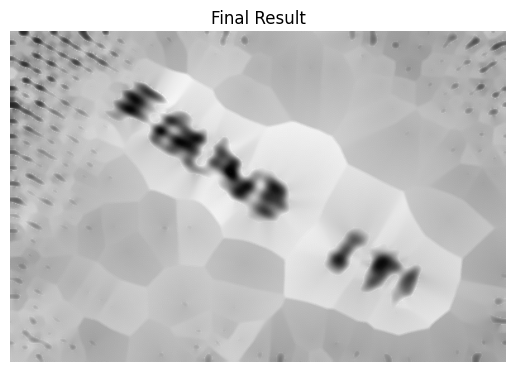

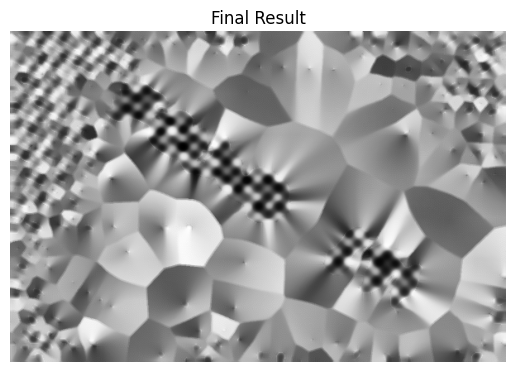

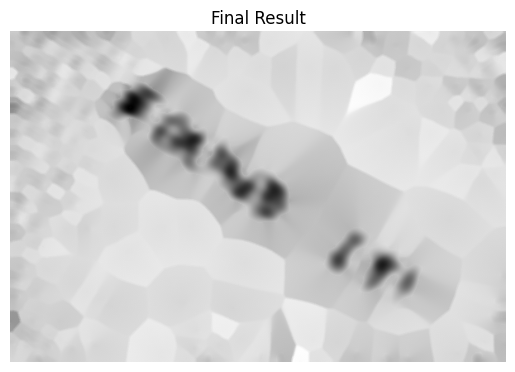

In [283]:
pipelines = [
    
    ["bilateral", "clahe", "dft", "notch", "low_pass", "idft", "gaussian", "thresholding"],
    ["dft", "notch", "low_pass", "idft", "clahe", "bilateral", "thresholding"],
    ["inpaint", "dft", "notch", "low_pass", "idft", "bilateral", "clahe", "thresholding"],
    ["dft", "low_pass", "idft", "bilateral", "gaussian", "thresholding", "clahe"],
    ["clahe", "dft", "notch", "idft", "bilateral", "gaussian", "thresholding","dft","low_pass","idft","bilateral","gaussian","thresholding"],  
]

for pipe in pipelines:
    run_pipeline(data, pipe, debug=False)

Step: inpaint


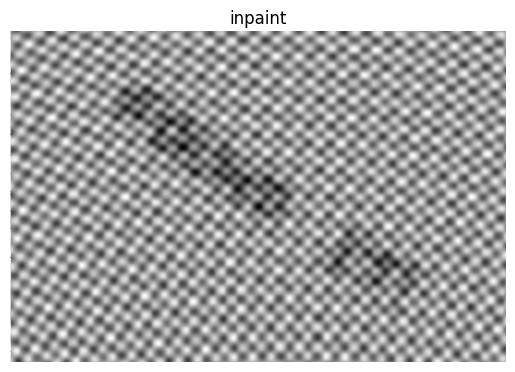

Step: clahe


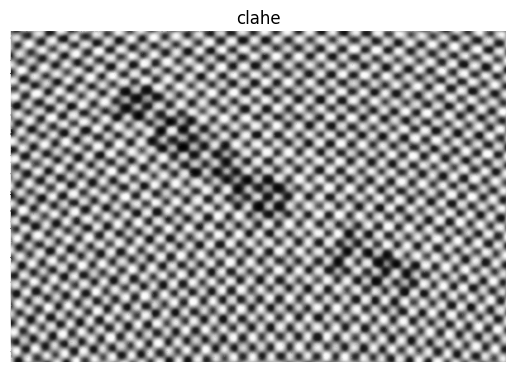

Step: dft


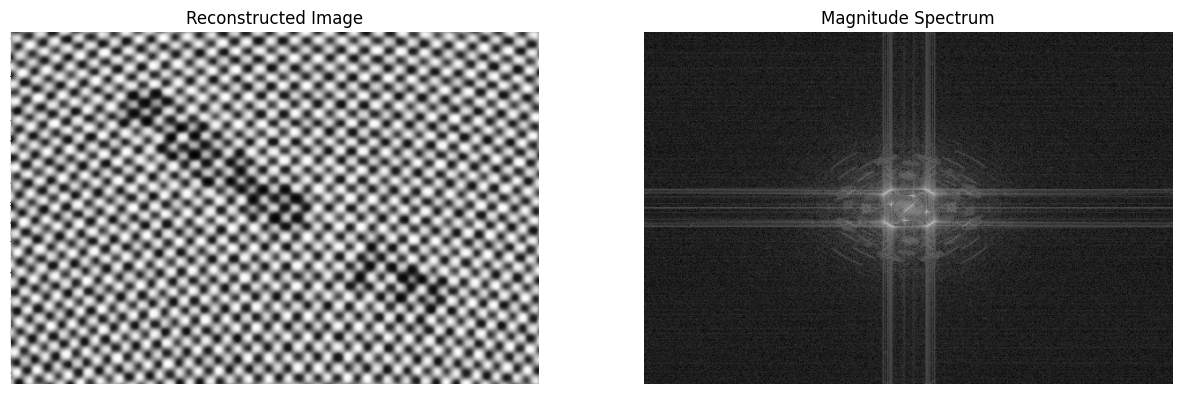

Step: notch


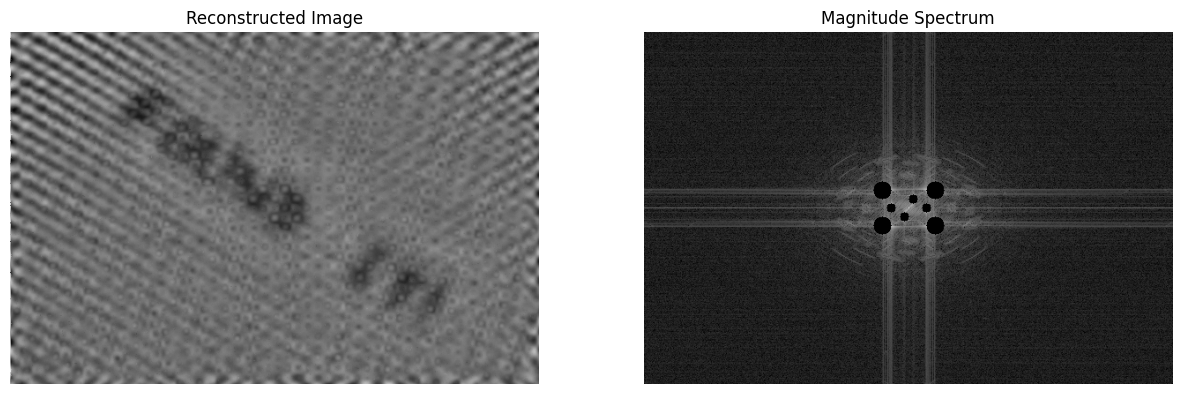

Step: low_pass


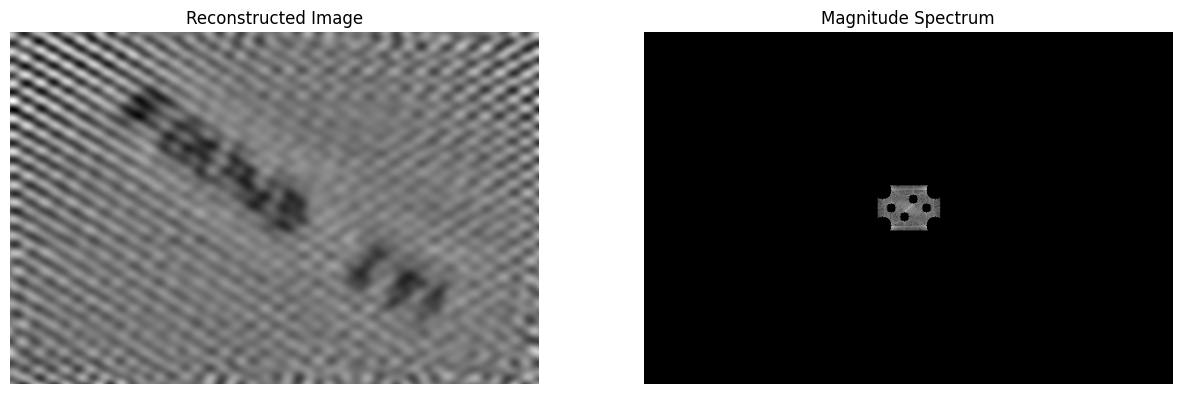

Step: idft


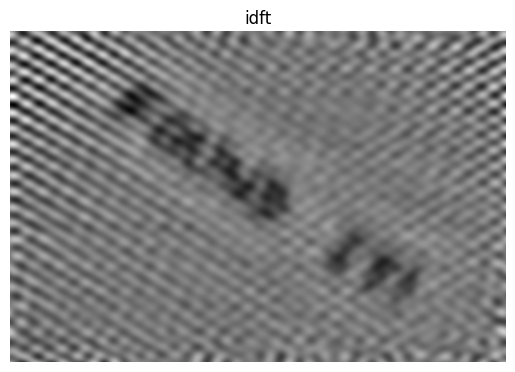

Step: bilateral


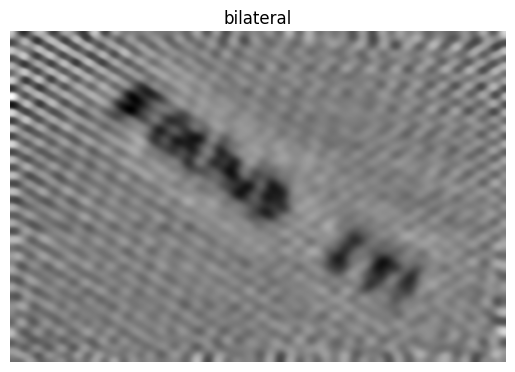

Step: thresholding


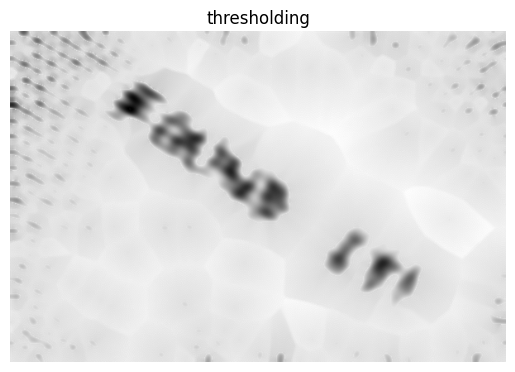

Step: clahe


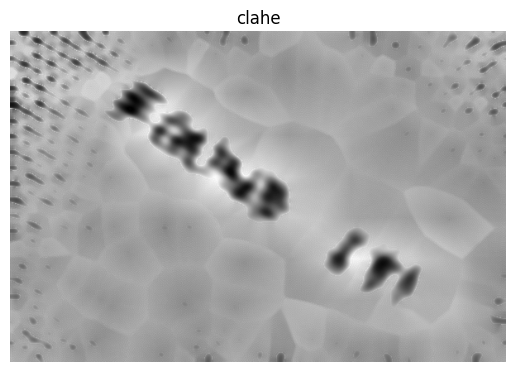

Step: gaussian


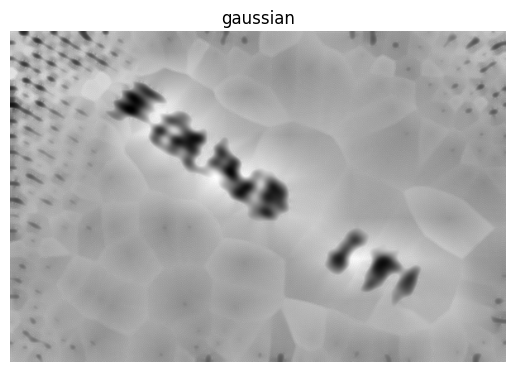

Step: dft


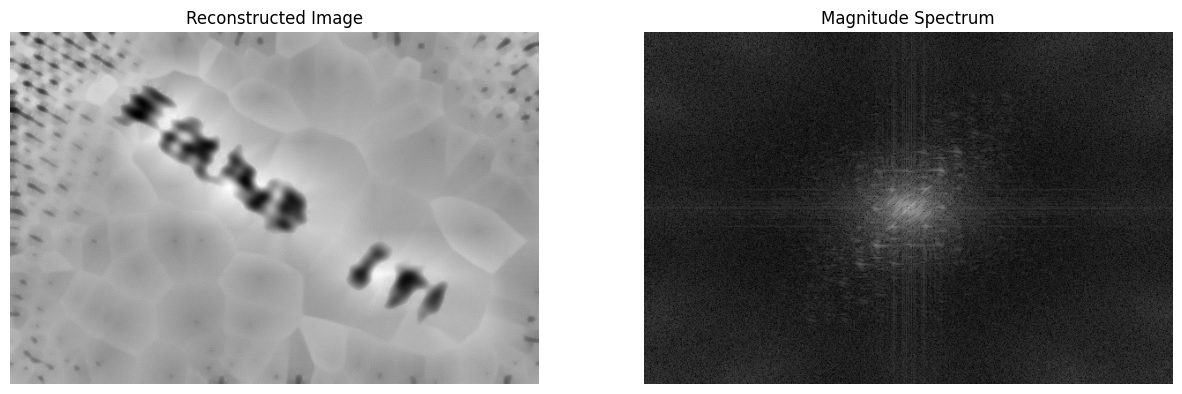

Step: unsharp


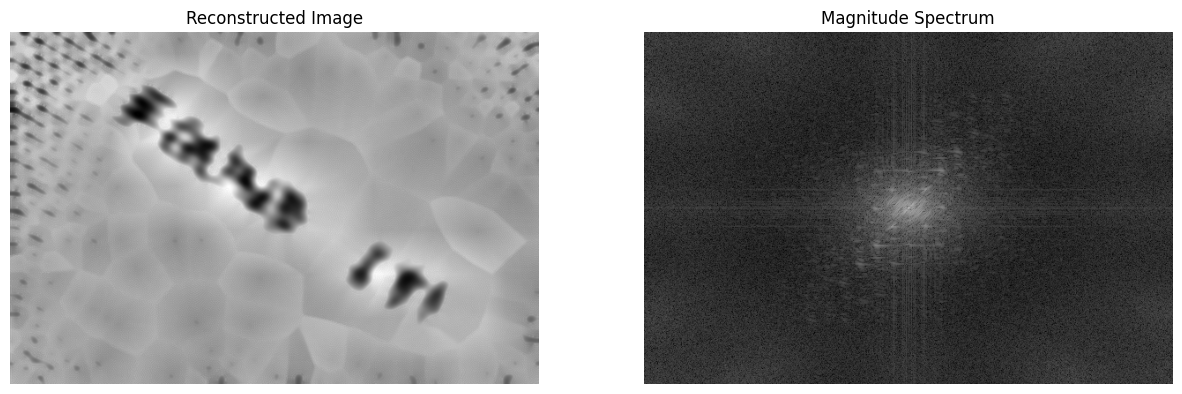

Step: idft


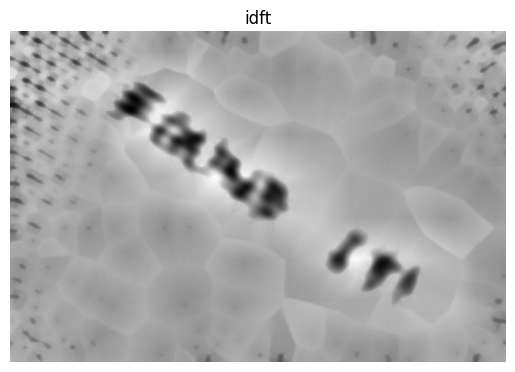

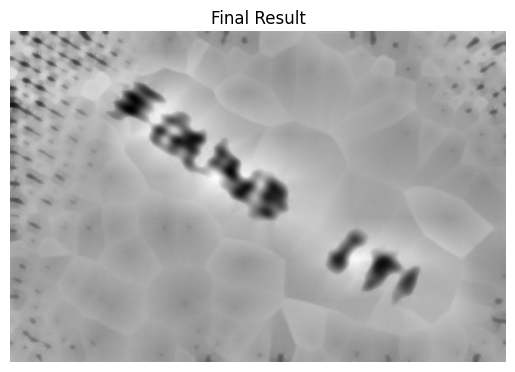

In [282]:

pipeline_order = ["inpaint","clahe","dft", "notch", "low_pass","idft", "bilateral", "thresholding", "clahe", "gaussian","dft","unsharp","idft"]
run_pipeline(data, pipeline_order, debug=True)